This notebook is implementing unbalanced OT on a 3D ground space on the non-zero-padded data-challenge data.

In this notebook, we repeat `OTUnbalanced_3D.ipynb` but now with normalized $pT$ to make $\kappa$ (`reg_m`) behavior less arbitrary.

# Information about data

The data we are using was a part of the [ML4Jets 2021 data challenge](https://indico.cern.ch/event/980214/contributions/4413658/attachments/2278124/3870358/ml4jets_data_challenge.pdf). It is publically available in `.h5` format so it's great for doing some preliminary exploration!

**Publication:**

E. Govorkova, E. Puljak, T. Aarrestad, M. Pierini, K. A. Woźniak and J. Ngadiuba, LHC physics dataset for unsupervised New Physics detection at 40 MHz, Sci. Data 9, 118 (2022),
doi:[10.1038/s41597-022-01187-8](https://www.nature.com/articles/s41597-022-01187-8), arXiv:2107.02157

**Data:**

NOTE: The original data had several bugs in it. The links in the original materials (i.e. publication and slides) point to the incorrect Version 1 of the data. Version 2 should be used instead. [This website](https://mpp-hep.github.io/ADC2021/) contains the correct links/descriptions/usage information.

- `background_for_training.h5`: 4 million Standard Model (SM) background "training" data ([link to data](https://zenodo.org/record/5046428#.ZB9yKezMKHu))
-  `Ato4l_lepFilter_13TeV_filtered.h5`: # Neutral scalar boson events, $A \rightarrow 4l$, mass = $50$ GeV ([link to data](https://zenodo.org/record/7152590#.ZB9yROzMKHu))
- `leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5`: # Leptoquark events, ${\rm LQ} \rightarrow b \tau$ ([link to data](https://zenodo.org/record/7152599#.ZB9yZOzMKHu))
- `hToTauTau_13TeV_PU20_filtered.h5`: # Scalar boson events, $h^0 \rightarrow \tau \tau$ ([link to data](https://zenodo.org/record/7152614#.ZB9ybOzMKHt))
- `hChToTauNu_13TeV_PU20_filtered.h5`: # Charged scalar boson events, $h^\pm \rightarrow \tau \nu$ ([link to data](https://zenodo.org/record/7152617#.ZB9yf-zMKHt))
- `BlackBox_background_mix.h5`: # Mystery events ([link to data](https://zenodo.org/record/5072068#.ZB9yk-zMKHt))

In [ ]:
sigAliasList    = ['sig_A', 'sig_h0', 'sig_hch', 'sig_LQ']
sigFilenameList = ['Ato4l_lepFilter_13TeV_filtered.h5', 'hToTauTau_13TeV_PU20_filtered.h5', 'hChToTauNu_13TeV_PU20_filtered.h5', 'leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5']

# Google Drive preliminaries (since we're running on Google Colab)

In [ ]:
#-- "Mount" Google Drive to access data and save files/images --#
# NOTE: If running locally, comment out this cell and change the basePath accordingly
# Reference: https://stackoverflow.com/questions/49031798/when-i-use-google-colaboratory-how-to-save-image-weights-in-my-google-drive
from google.colab import drive
drive.mount('/content/gdrive')

# You will be asked to sign into a Google account and give GoogleColab access

Mounted at /content/gdrive


In [ ]:
# To check that mounting worked, uncomment and run the following. You should see the contents of the directory listed.
! ls '/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/Data/'

Ato4l_lepFilter_13TeV_filtered.h5
background_for_training.h5
BlackBox_background_mix.h5
hChToTauNu_13TeV_PU20_filtered.h5
hToTauTau_13TeV_PU20_filtered.h5
leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5
OldBuggedDatasets


In [ ]:
#-- Set base directory and data directory path --#
basePath   = '/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/'
dataPath   = 'Data/'

bkgPath    = basePath+dataPath+'background_for_training.h5'
sigPathList = []
for x in sigFilenameList:
  sigPathList.append(basePath+dataPath+x)

# Import libraries

We'll eventually be using the PyOT library to compute Wasserstein distances for now (see [here](https://pythonot.github.io/index.html)).

In [ ]:
!pip install POT

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 6.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
from numpy.random import RandomState
import numpy.ma as ma

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

import h5py
import ot
from numpy.random import Generator, PCG64
from sklearn import metrics
import itertools

# Functions

To keep things tidy, functions are externally defined in `centralFunctions.ipynb`. We run this notebook from here which defines the contained functions as if they were written here.


In [1]:
%cd /content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/
%run centralFunctions.ipynb

[Errno 2] No such file or directory: '/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/'
/content


Exception: ignored

# Load data

For more details on the data structure, see [this exploratory notebook](https://colab.research.google.com/drive/138CL8n4gCtramqaaI-i0EUZ7n4f1SWVh?usp=sharing).

In [ ]:
dataDict = {}
dataDict['bkg'] = h5py.File(bkgPath, 'r')

for i in range(len(sigAliasList)):
  alias   = sigAliasList[i]
  sigPath = sigPathList[i]
  dataDict[alias] = h5py.File(sigPath, 'r')

# Optimal Transport Anomaly Score: Unbalanced

We'll be using the 2-Wasserstein distance squared as our anomaly score. We assume the ground space is 3 dimensional $(p_T/\sum p_T, \eta, \phi)$.

       OTSCHEME:  Determines what scheme will be used to calculate the OT distance.
                  Note the exact meaning varies somewhat depending on the choice of COSTSCHEME.
                  It's a dictionary of 3 booleans cooresponding to whether the PT is normalized,
                  whether the OT calculation is balanced, and whether the zero padding should be
                  removed. Namely,
                  OTSCHEME['normPT']      ==True:  Means that the pT should be normalized;
                                         ==False:  Means that the pT should be unnormalized
                  OTSCHEME['balanced']    ==True:  Means that the OT calculation should be balanced;
                                         ==False:  Means that the OT calculation should be unbalanced
                  OTSCHEME['noZeroPad']   ==True:  Means that the zero padding should be removed;
                                         ==False:  Means that the zero padding should be kept
                  OTSCHEME['individualOT']==True:  Means that the OT calculation is done on each species separately;
                                         ==False:  Means that the OT calculation is done ignoring species type    
     COSTSCHEME:  Determines what scheme will be used to calculate the ground cost matrix. Options are:
                  - 1DpT: Ground space is pT only
                  - 2D:   Ground space is 2D (eta,phi); note mass is pT
                  - 3D:   Ground space is 3D (pT,eta,phi); note mass is uniform

In [ ]:
OTSCHEME = {}
OTSCHEME['normPT']       = True  # pT should be normalized per event
OTSCHEME['balanced']     = False # OT calculation is unbalanced
OTSCHEME['noZeroPad']    = True  # zero padding is removed
OTSCHEME['individualOT'] = False # Don't calculate individual species OT
COSTSCHEME            = '3D'  # pT, eta, phi ground space

In [ ]:
# Define colors to use for 4 signal types
SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                              RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                              RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                              RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                              ])

## (L2, $\kappa = 0.1$)

In [ ]:
kwargs          = {}
kwargs['div']   = 'l2'
kwargs['reg_m'] = 0.1

### Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

### Calculate OT anomaly scores

In [ ]:
# nEvents = 100 takes about xxs of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict[alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

In [ ]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

### Plot anomaly scores for all signal types

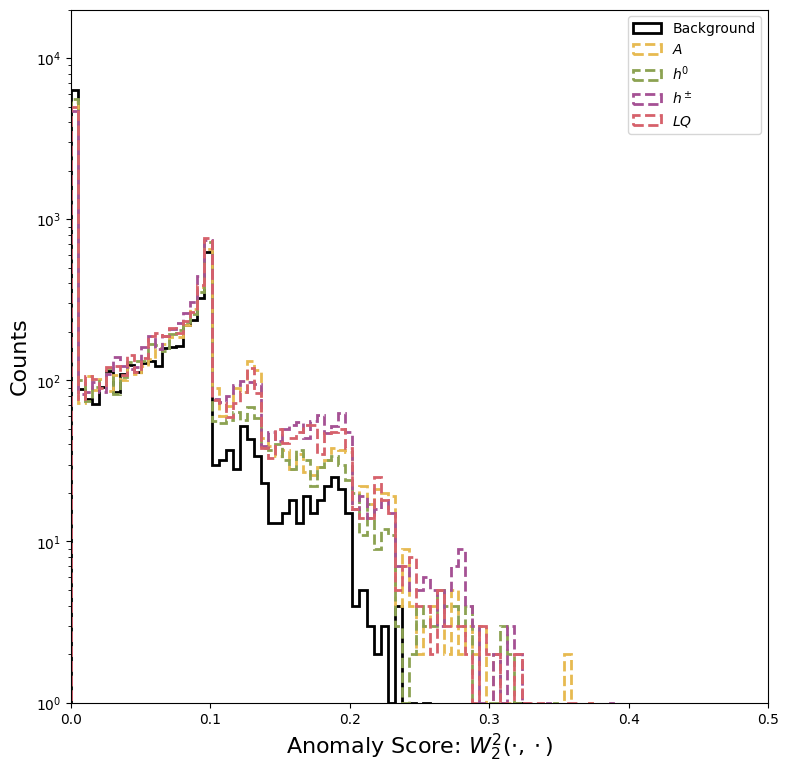

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 0.5)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 2e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

### Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

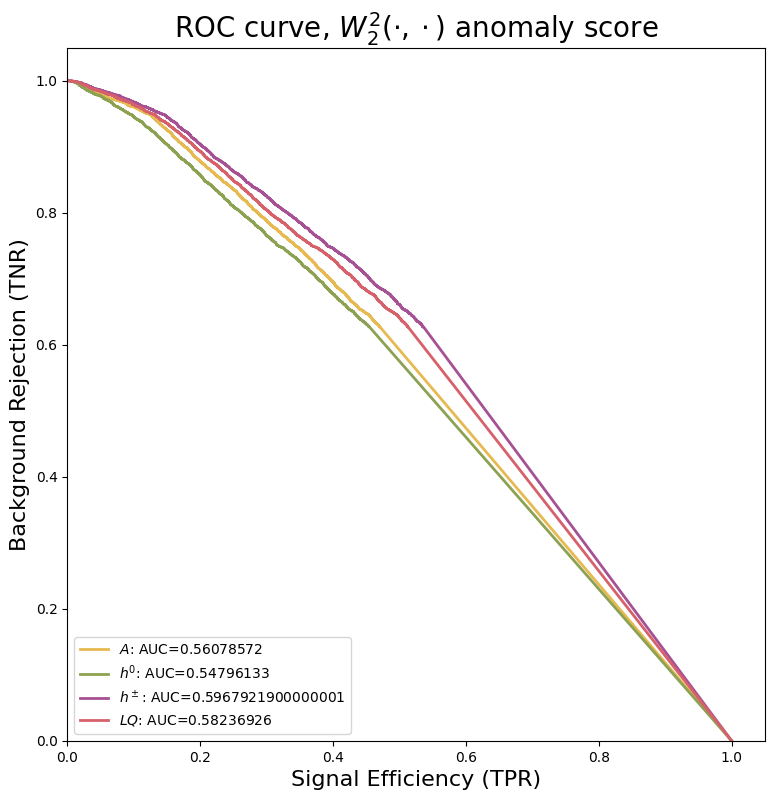

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

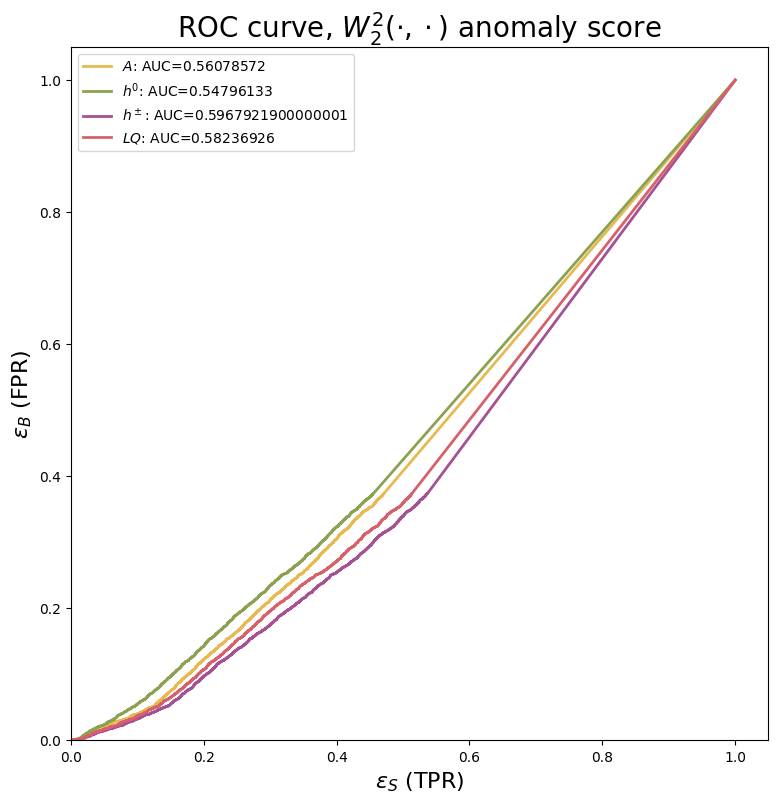

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

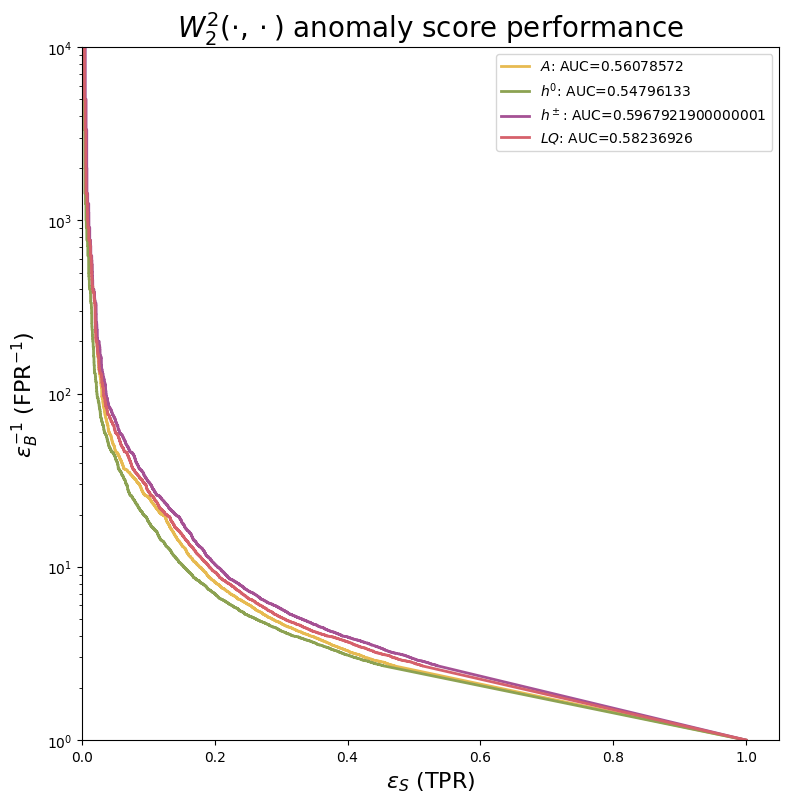

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 1e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

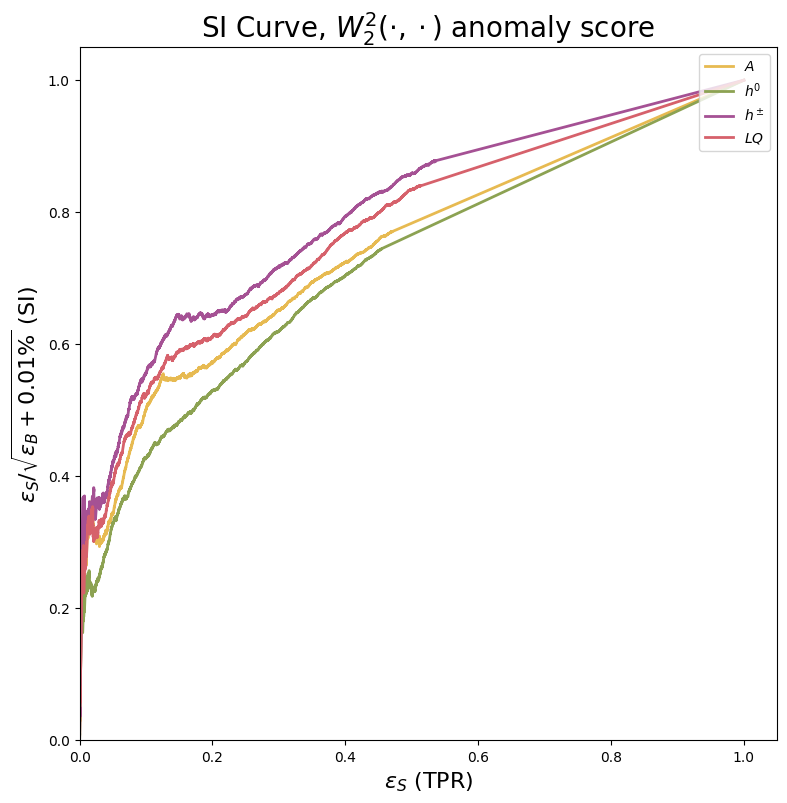

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.0001 0.0005 0.0005 0.0052]
[0.         0.01       0.05       0.03535534 0.36769553]


### Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.56078572
     $h^0$: 0.54796133
   $h^\pm$: 0.5967921900000001
      $LQ$: 0.58236926


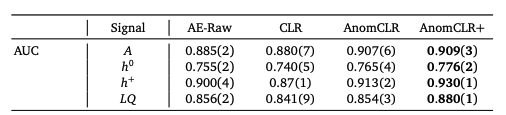

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[2354, 2597, 2130, 2328]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 4.721435316336167 (TPR=0.3)
     $h^0$: 4.271678769756514 (TPR=0.3)
   $h^\pm$: 5.730659025787966 (TPR=0.2999)
      $LQ$: 5.109862033725089 (TPR=0.3001)


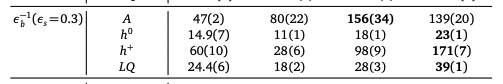

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.6517120879556718 (TPR=0.3)
     $h^0$: 0.6199088112329391 (TPR=0.3)
   $h^\pm$: 0.7177188392315322 (TPR=0.2999)
      $LQ$: 0.6782029143657057 (TPR=0.3001)


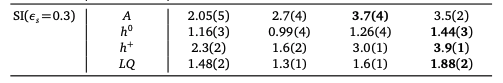

## (L2, $\kappa = 1$)

In [ ]:
kwargs          = {}
kwargs['div']   = 'l2'
kwargs['reg_m'] = 1.

### Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

### Calculate OT anomaly scores

In [ ]:
# nEvents = 100 takes about xxs of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict[alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

In [ ]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

### Plot anomaly scores for all signal types

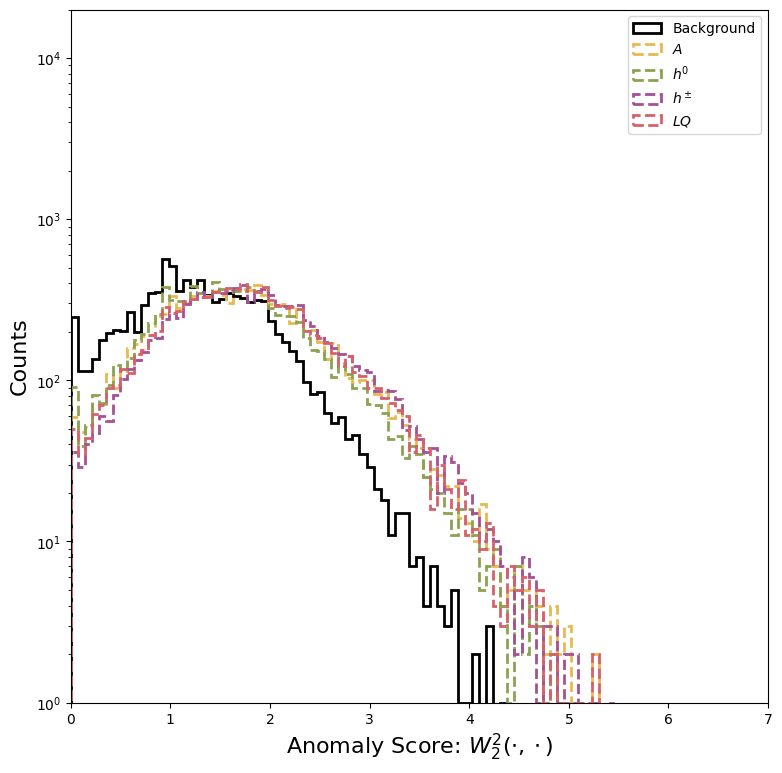

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 7)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 2e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

### Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

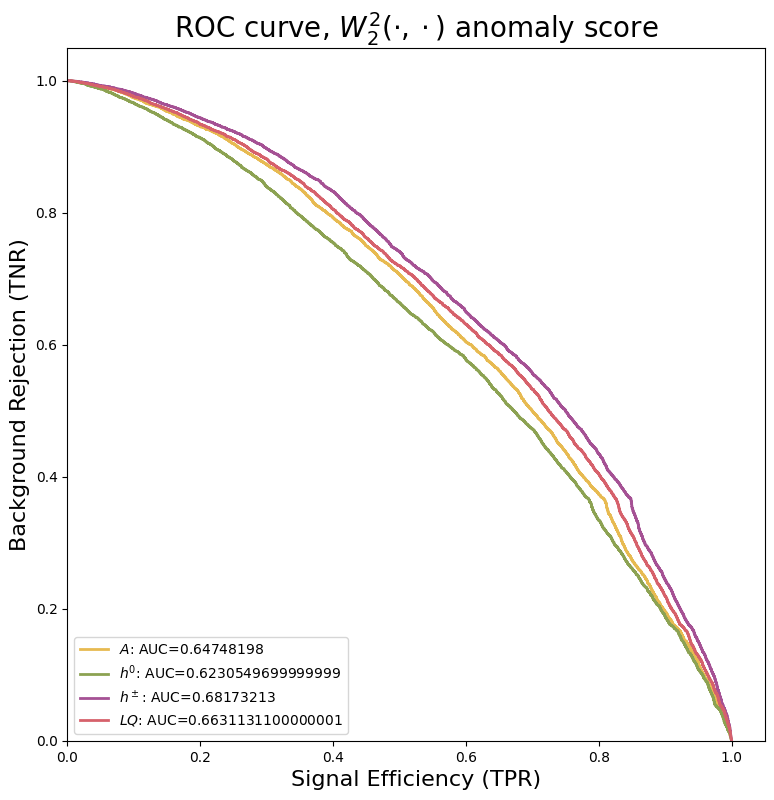

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

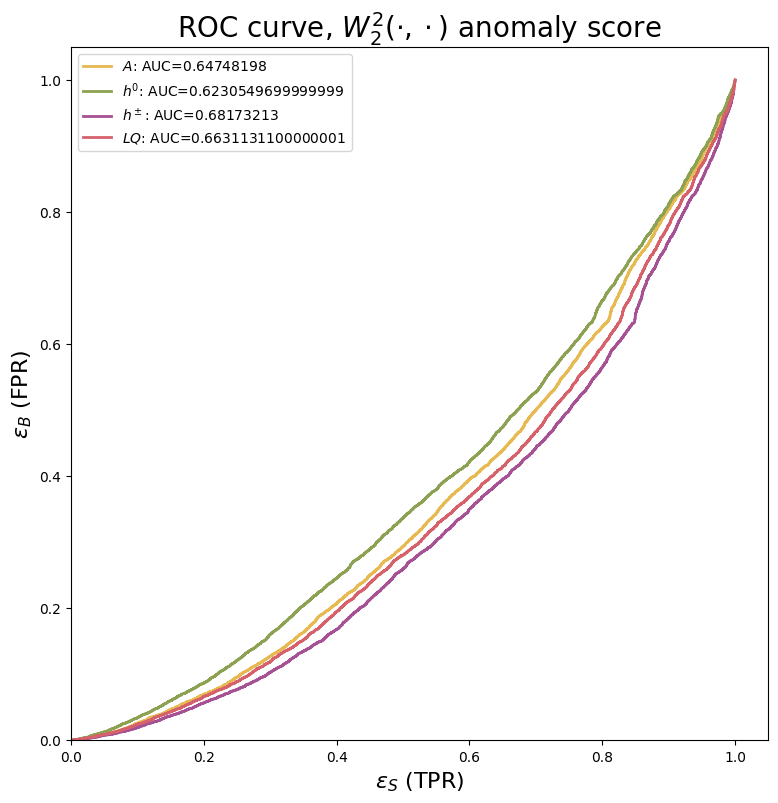

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

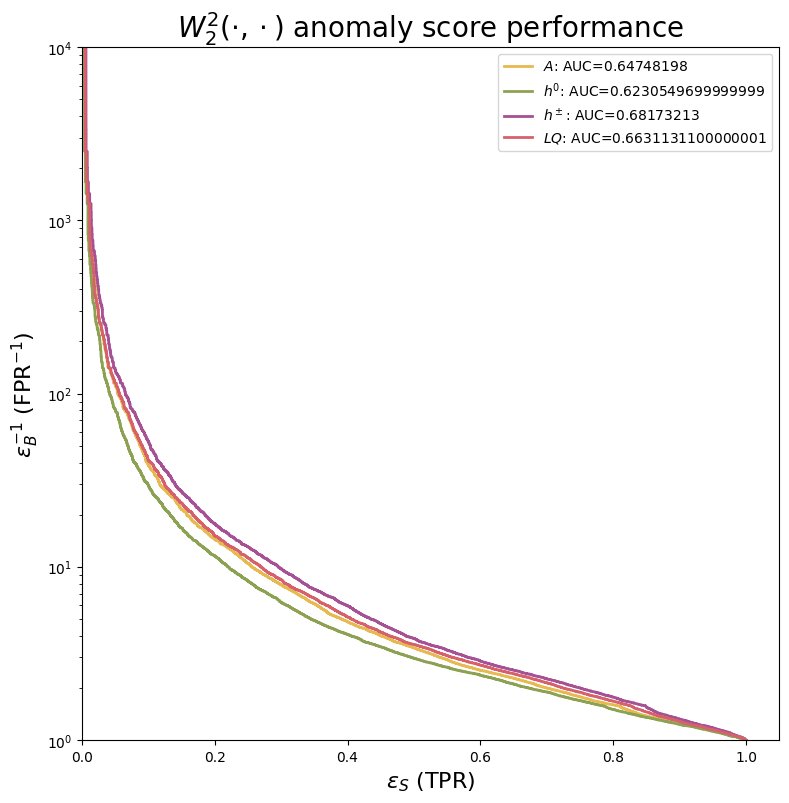

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 1e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

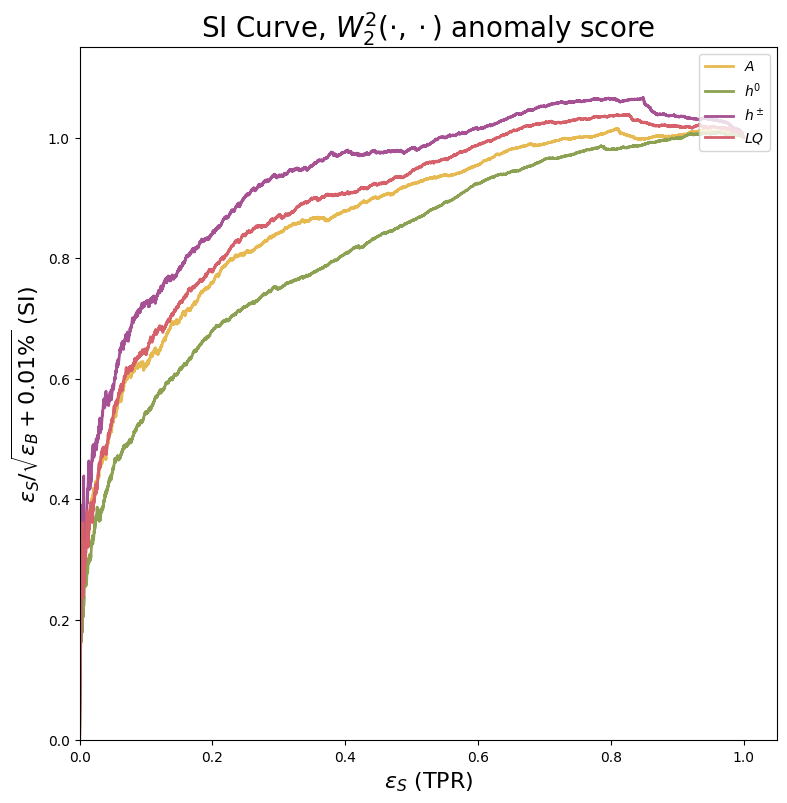

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.15)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.0001 0.0039 0.0039 0.0062]
[0.         0.01       0.39       0.27577164 0.4384062 ]


### Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.64748198
     $h^0$: 0.6230549699999999
   $h^\pm$: 0.68173213
      $LQ$: 0.6631131100000001


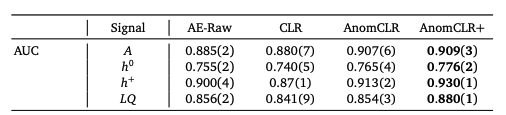

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[1756, 2062, 1502, 1648]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 7.874015748031496 (TPR=0.3)
     $h^0$: 6.242197253433208 (TPR=0.3)
   $h^\pm$: 9.775171065493646 (TPR=0.2997)
      $LQ$: 8.438818565400844 (TPR=0.3001)


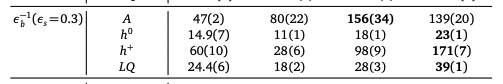

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.8414890701798216 (TPR=0.3)
     $h^0$: 0.7492978622271093 (TPR=0.3)
   $h^\pm$: 0.9365625000000001 (TPR=0.2997)
      $LQ$: 0.871412230160631 (TPR=0.3001)


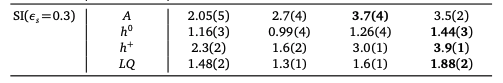

##(L2, $\kappa = 5$)

In [ ]:
kwargs          = {}
kwargs['div']   = 'l2'
kwargs['reg_m'] = 5.

### Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

### Calculate OT anomaly scores

In [ ]:
# nEvents = 100 takes about xxs of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict[alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

In [ ]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

### Plot anomaly scores for all signal types

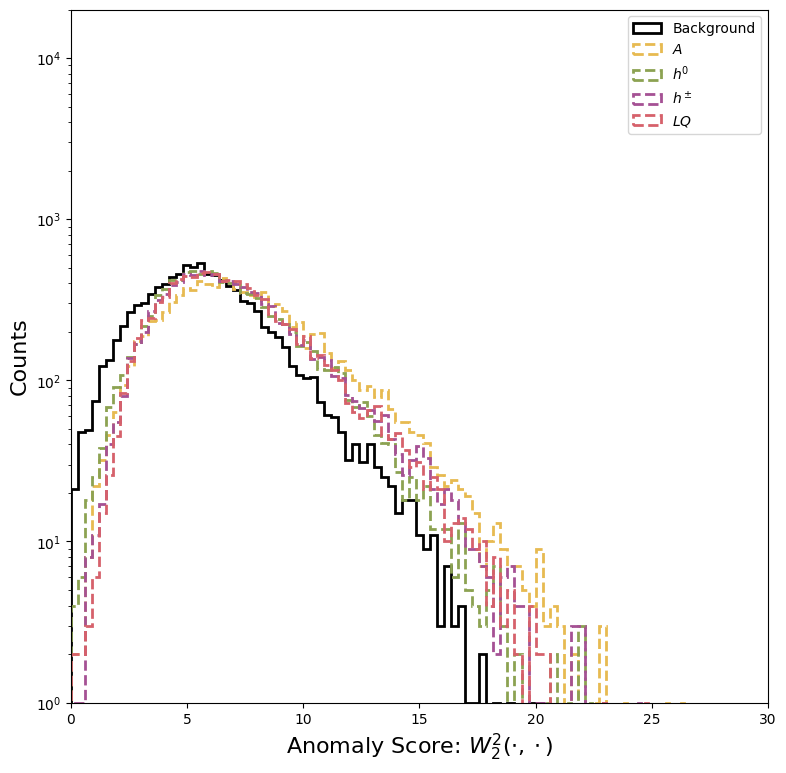

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 30)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 2e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

### Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

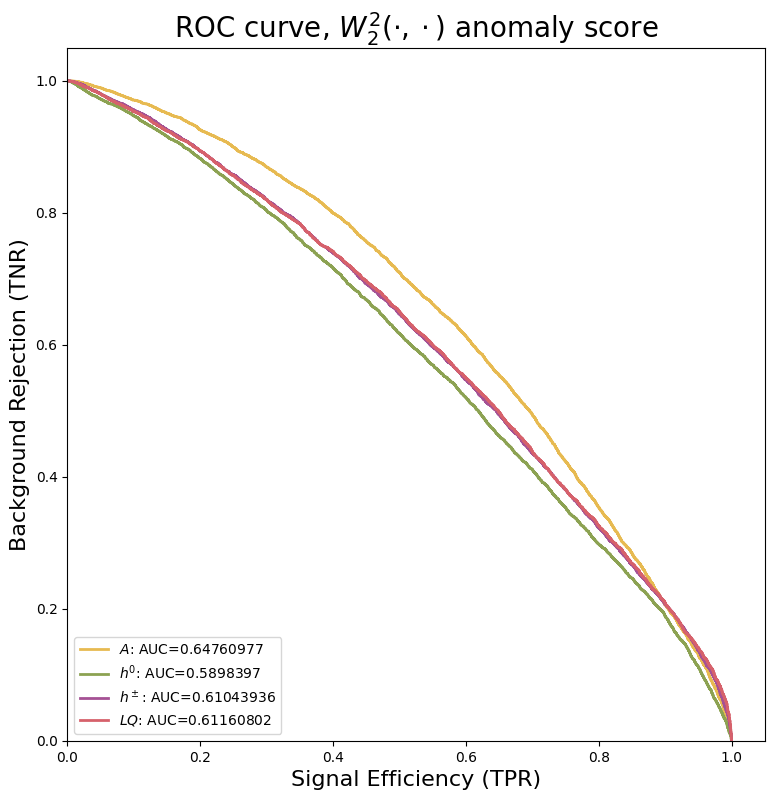

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

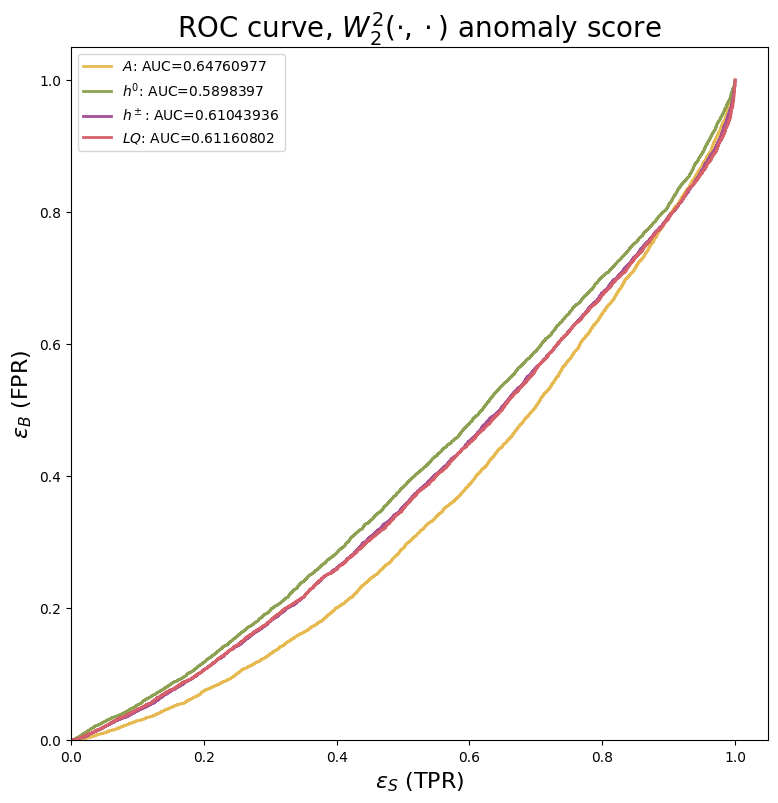

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

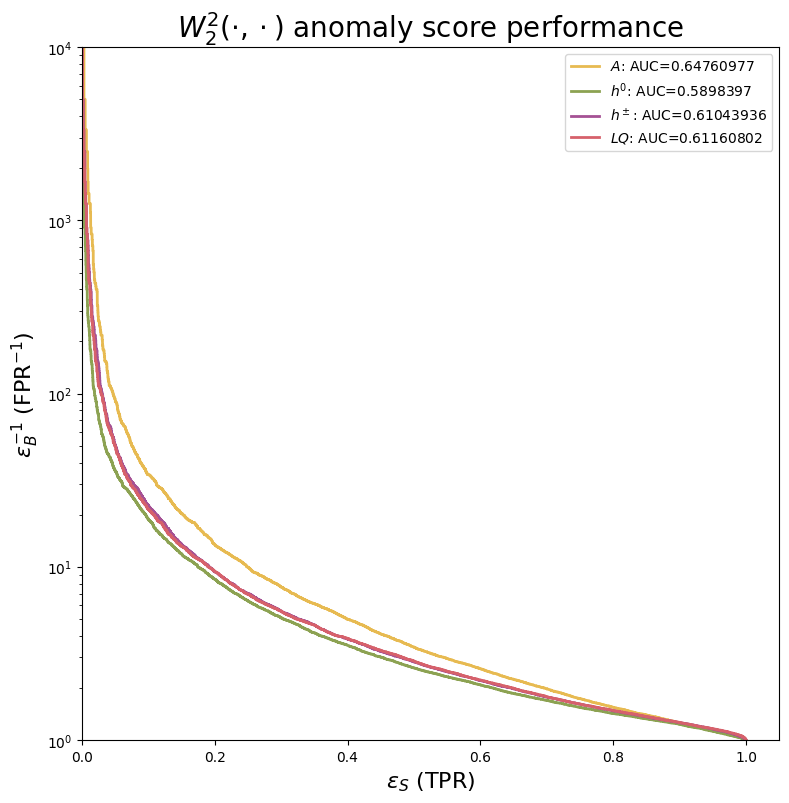

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 1e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

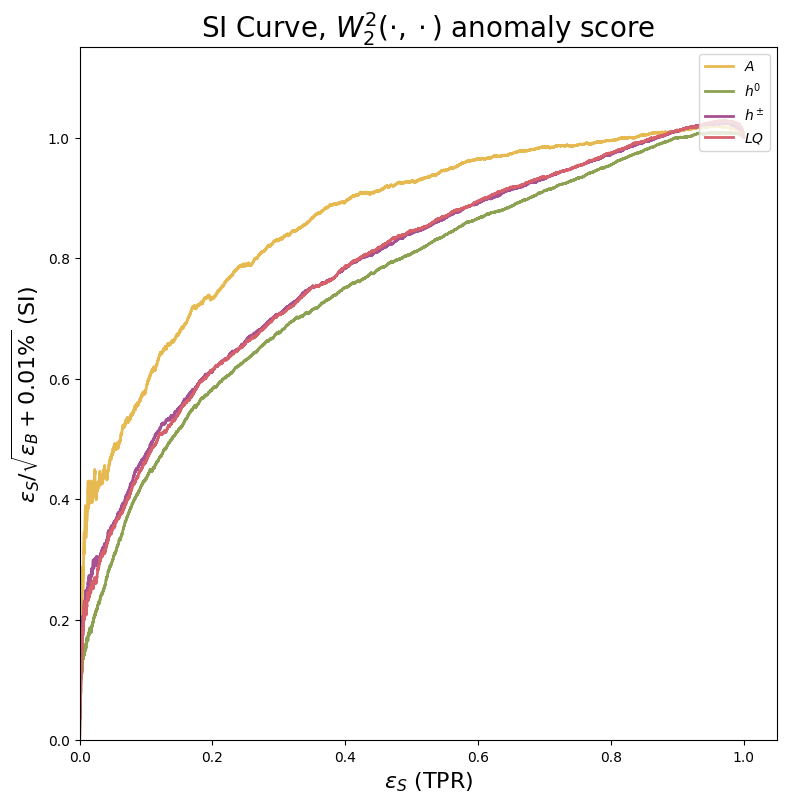

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.15)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.0001 0.001  0.001  0.0011]
[0.         0.01       0.1        0.07071068 0.07778175]


### Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.64760977
     $h^0$: 0.5898397
   $h^\pm$: 0.61043936
      $LQ$: 0.61160802


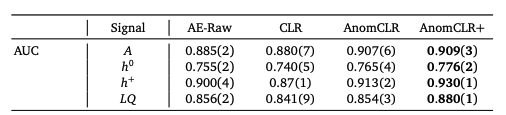

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[1774, 2394, 2190, 2202]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 7.656967840735069 (TPR=0.2999)
     $h^0$: 5.099439061703213 (TPR=0.3)
   $h^\pm$: 5.558643690939411 (TPR=0.3)
      $LQ$: 5.555555555555555 (TPR=0.2998)


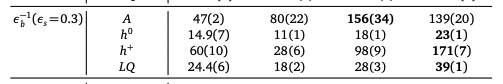

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.8295425588384565 (TPR=0.2999)
     $h^0$: 0.6772854614785964 (TPR=0.3)
   $h^\pm$: 0.7071067811865475 (TPR=0.3)
      $LQ$: 0.7064391708097834 (TPR=0.2998)


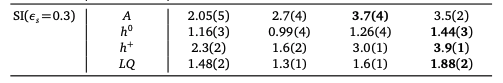

## (KL, $\kappa = 0.1$)

In [ ]:
kwargs          = {}
kwargs['div']   = 'kl'
kwargs['reg_m'] = 0.1

### Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

### Calculate OT anomaly scores

In [ ]:
# nEvents = 100 takes about xxs of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict[alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

In [ ]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

### Plot anomaly scores for all signal types

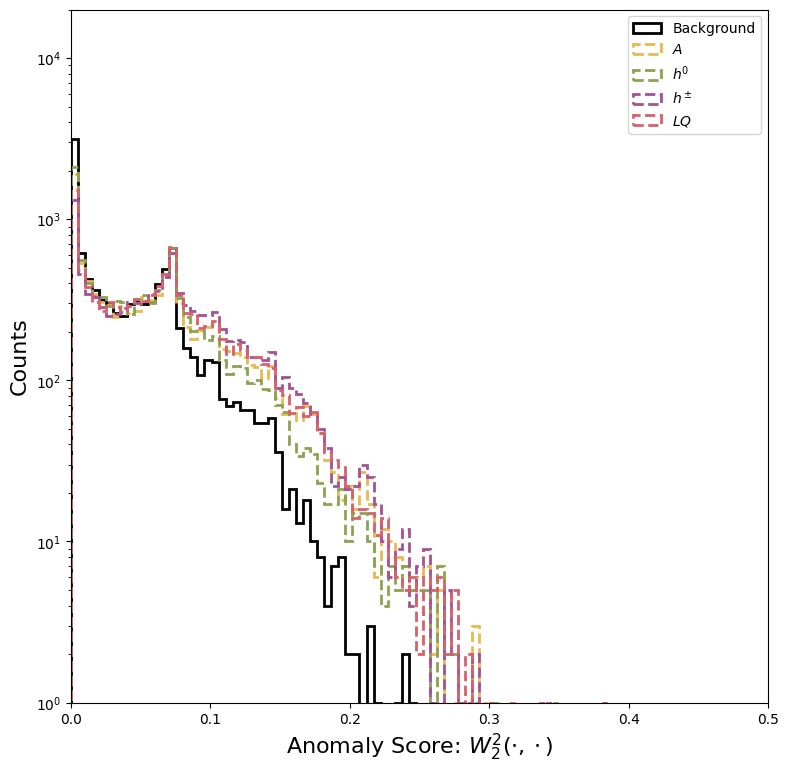

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 0.5)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 2e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

### Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

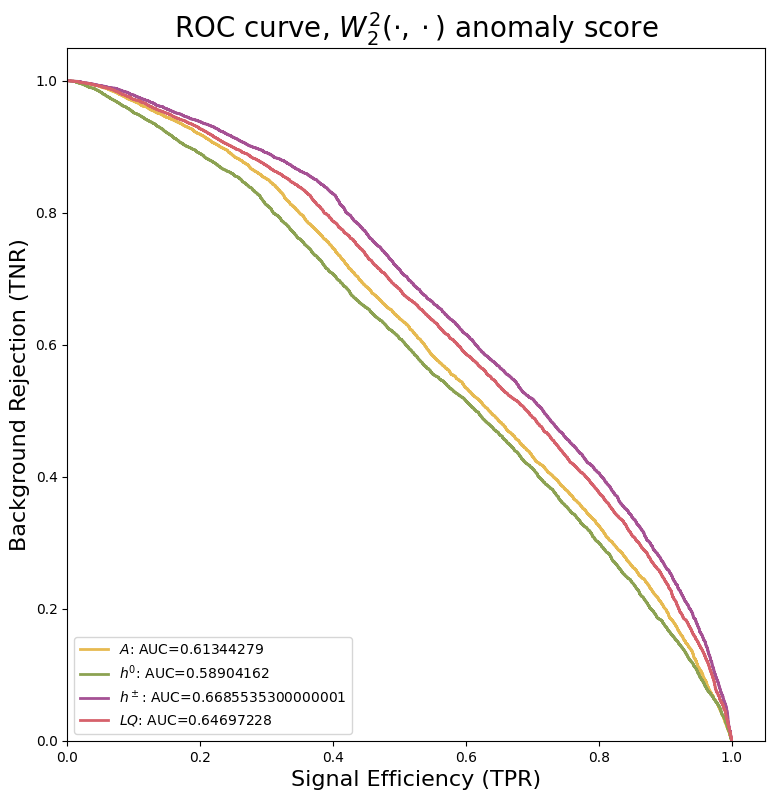

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

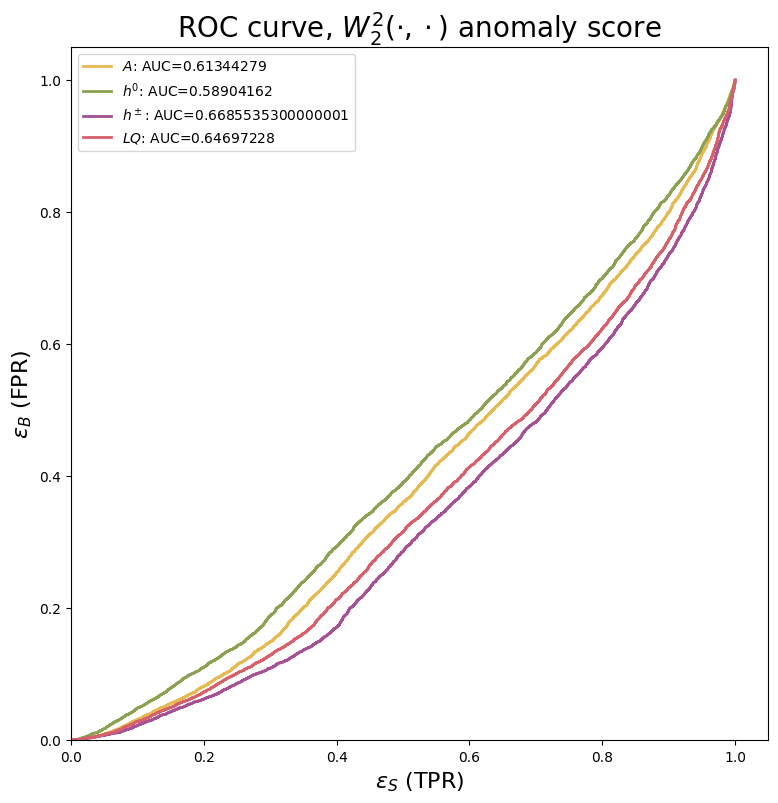

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

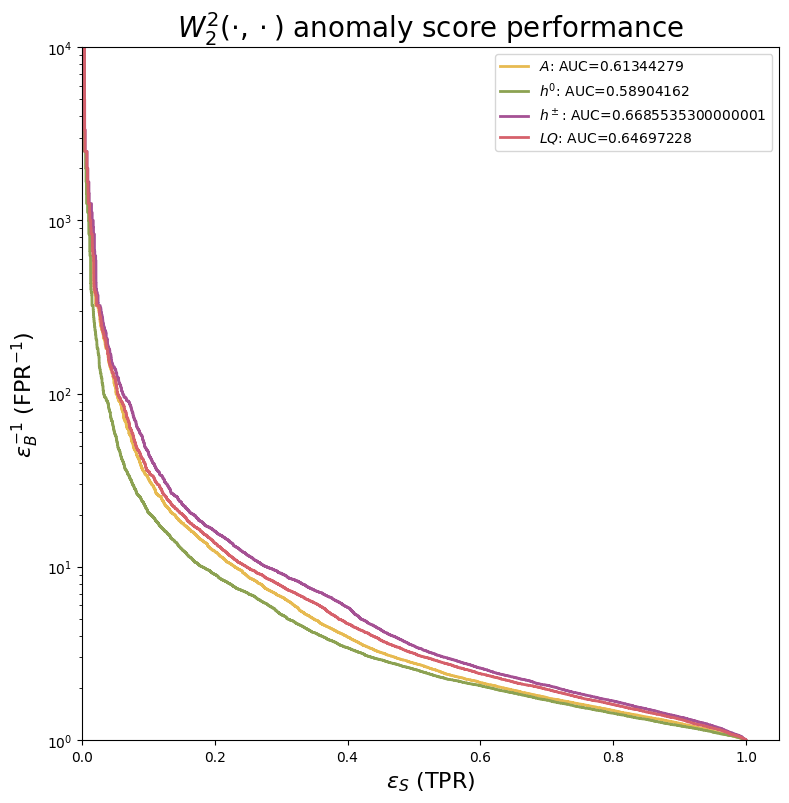

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 1e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

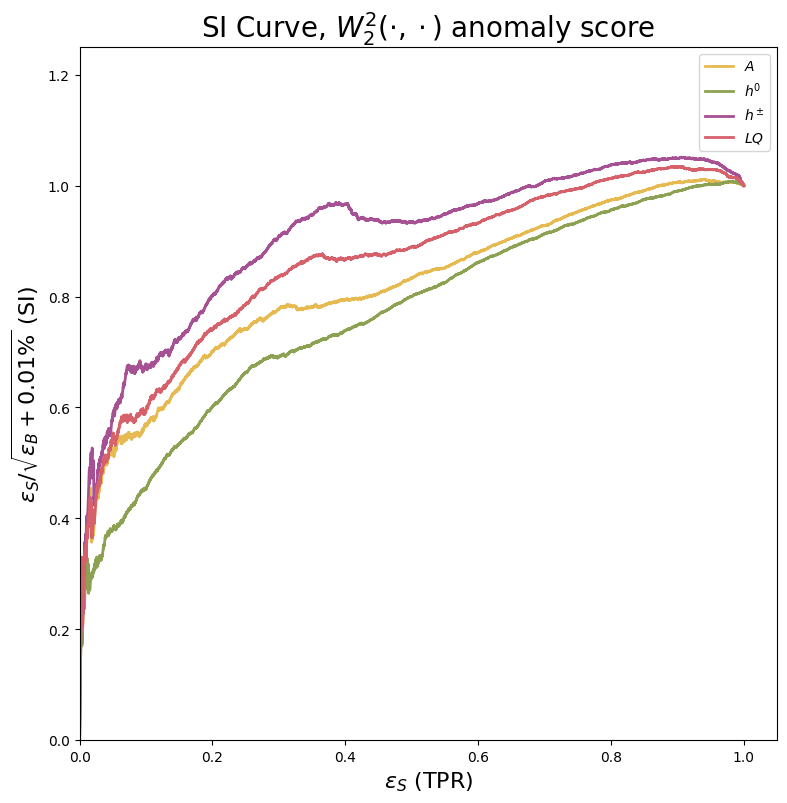

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.25)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.0001 0.0032 0.0032 0.0037]
[0.         0.01       0.32       0.22627417 0.26162951]


### Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.61344279
     $h^0$: 0.58904162
   $h^\pm$: 0.6685535300000001
      $LQ$: 0.64697228


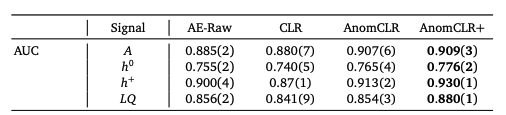

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[1916, 2278, 1536, 1776]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 6.729475100942126 (TPR=0.2998)
     $h^0$: 5.31632110579479 (TPR=0.3)
   $h^\pm$: 9.191176470588236 (TPR=0.2999)
      $LQ$: 7.776049766718508 (TPR=0.2999)


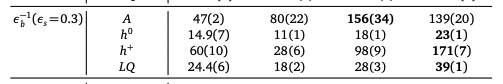

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.7774565812374876 (TPR=0.2998)
     $h^0$: 0.6915306683363611 (TPR=0.3)
   $h^\pm$: 0.9087878787878787 (TPR=0.2999)
      $LQ$: 0.8359632626704218 (TPR=0.2999)


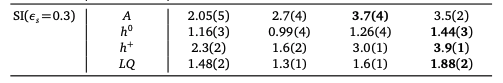

## (KL, $\kappa = 1$)

In [ ]:
kwargs          = {}
kwargs['div']   = 'kl'
kwargs['reg_m'] = 1.

### Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

### Calculate OT anomaly scores

In [ ]:
# nEvents = 100 takes about xxs of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict[alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

In [ ]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

### Plot anomaly scores for all signal types

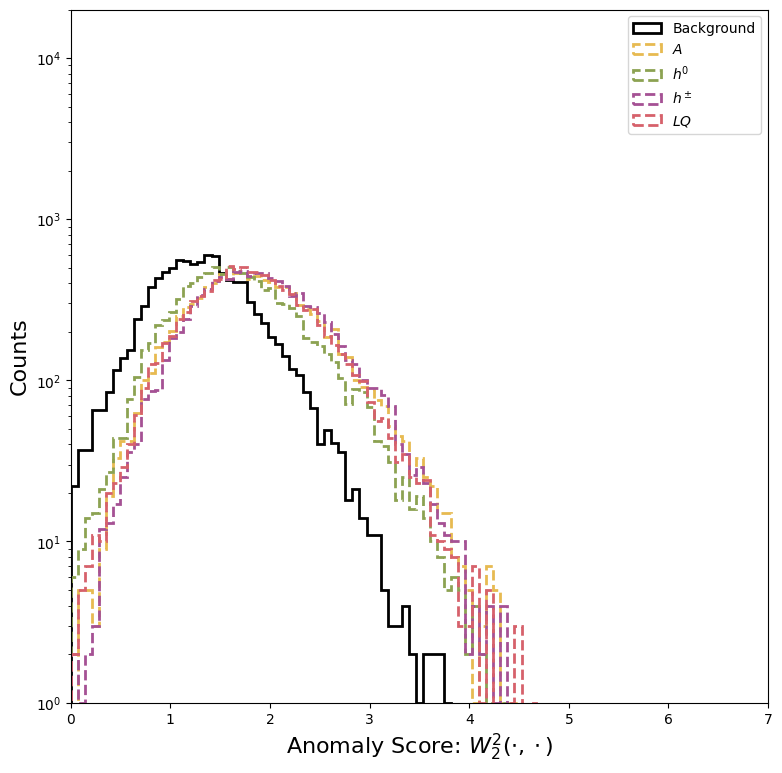

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 7)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 2e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

### Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

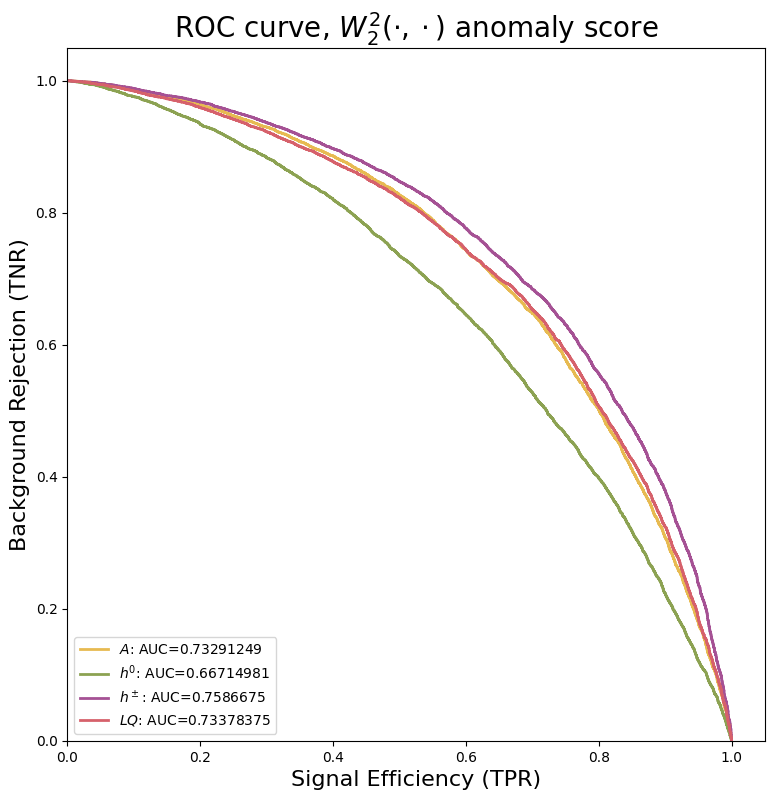

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

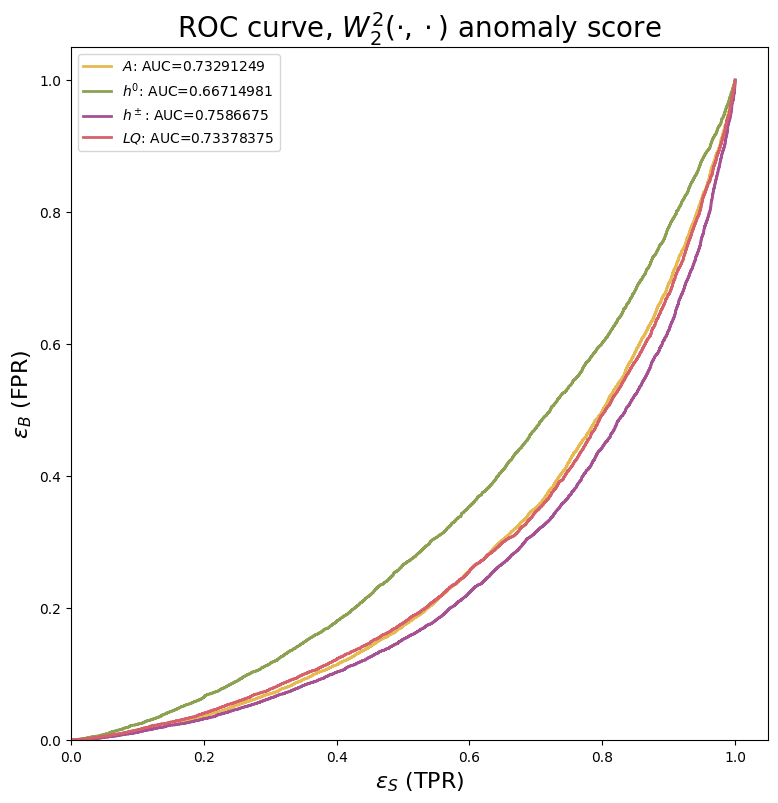

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

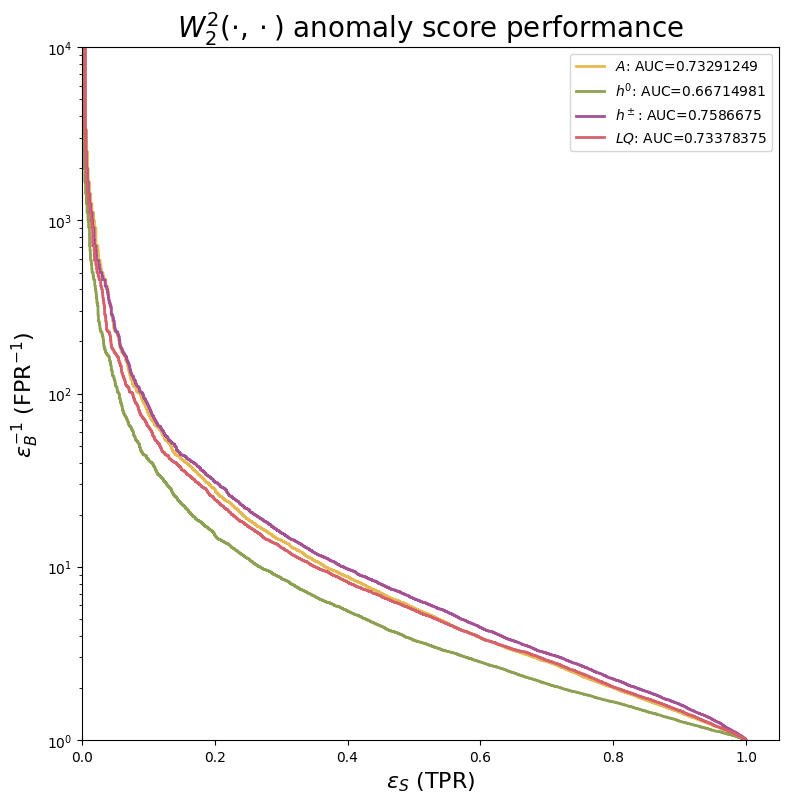

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 1e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

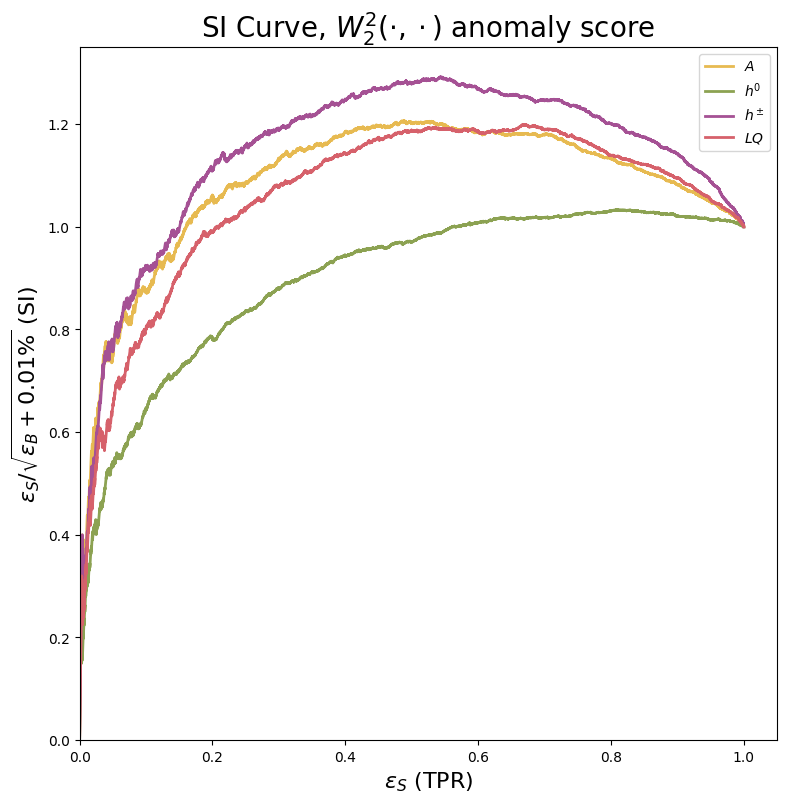

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.35)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.0001 0.004  0.004  0.0051]
[0.         0.01       0.4        0.28284271 0.36062446]


### Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.73291249
     $h^0$: 0.66714981
   $h^\pm$: 0.7586675
      $LQ$: 0.73378375


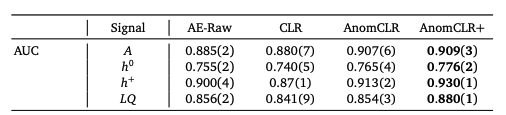

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[1072, 1644, 1044, 1196]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 14.306151645207438 (TPR=0.2998)
     $h^0$: 8.605851979345955 (TPR=0.3)
   $h^\pm$: 15.748031496062993 (TPR=0.3004)
      $LQ$: 12.903225806451614 (TPR=0.3)


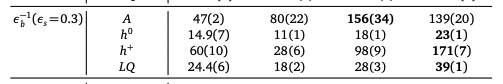

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 1.133137490081663 (TPR=0.2998)
     $h^0$: 0.8796935290617334 (TPR=0.3)
   $h^\pm$: 1.1911634817486523 (TPR=0.3004)
      $LQ$: 1.0769372379266071 (TPR=0.3)


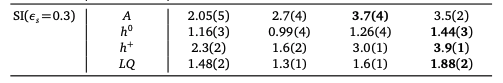

## (KL, $\kappa = 5$)

In [ ]:
kwargs          = {}
kwargs['div']   = 'kl'
kwargs['reg_m'] = 5.

### Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

### Calculate OT anomaly scores

In [ ]:
# nEvents = 100 takes about xxs of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTDistance(scoreDict['bkgEvents1'], scoreDict[alias], OTSCHEME=OTSCHEME, COSTSCHEME=COSTSCHEME, kwargs=kwargs)

In [ ]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

### Plot anomaly scores for all signal types

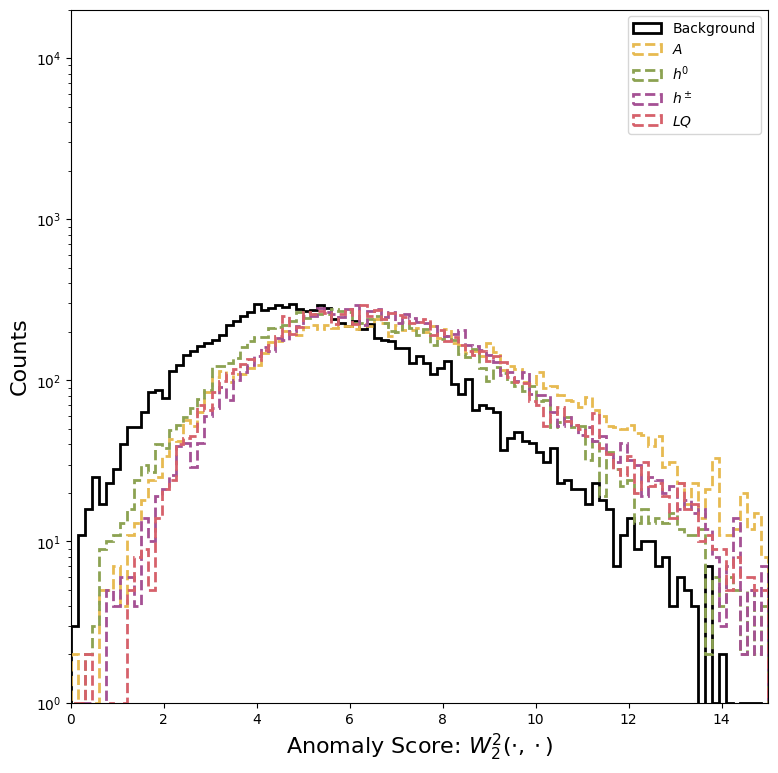

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 15)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 2e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

### Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

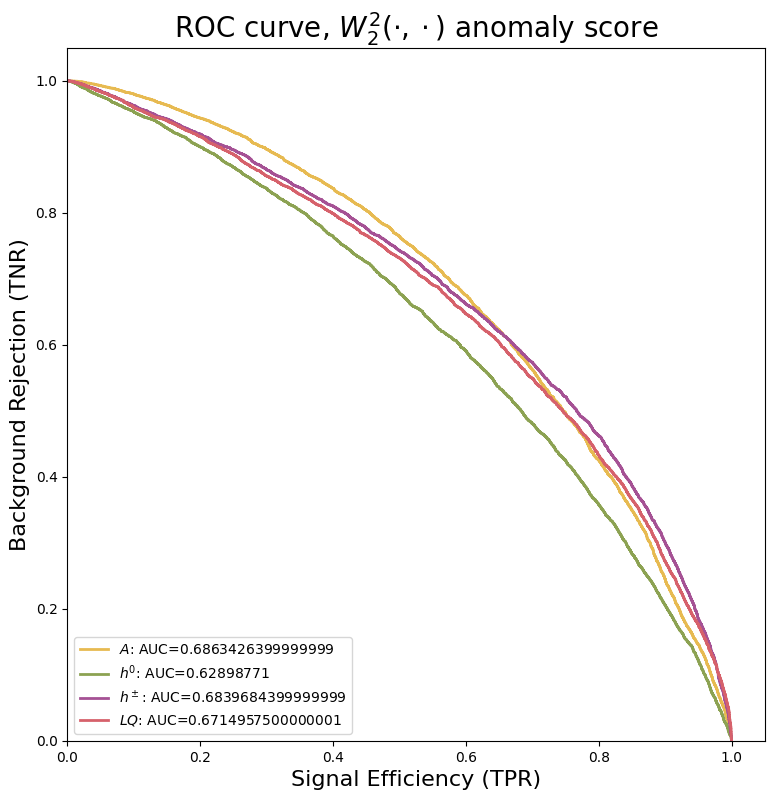

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

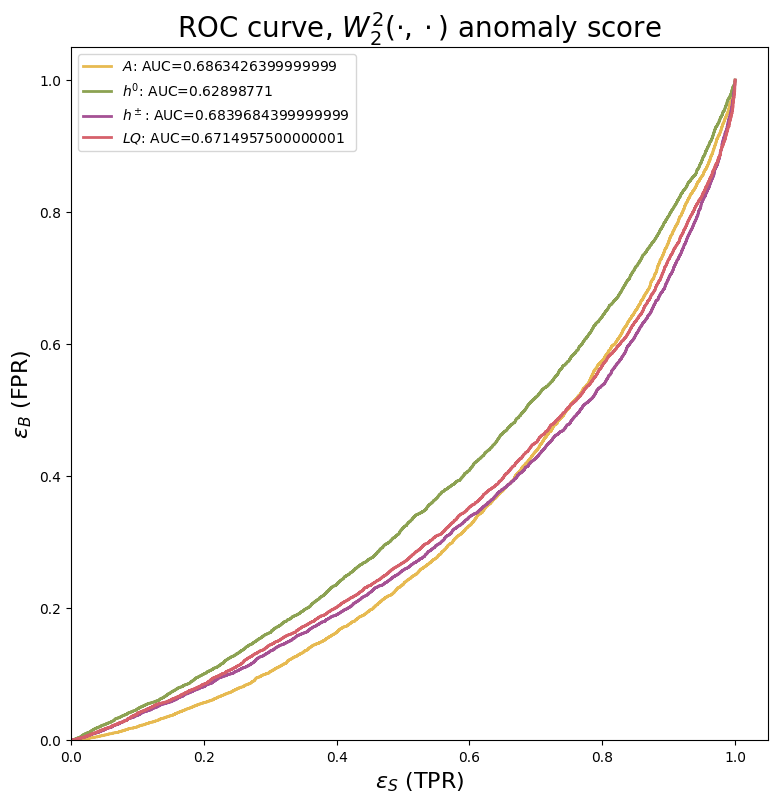

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

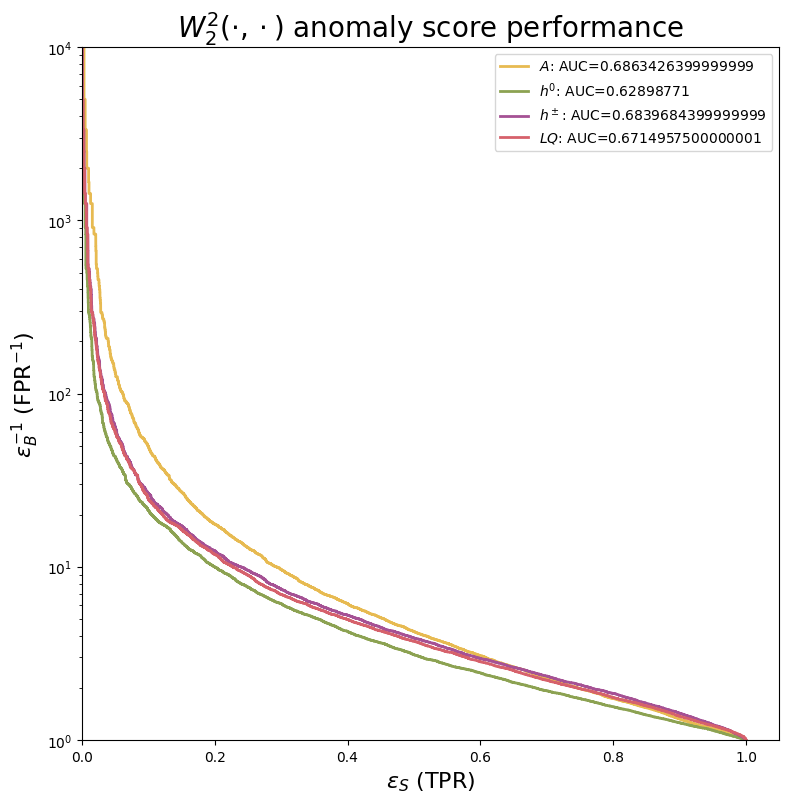

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 1e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

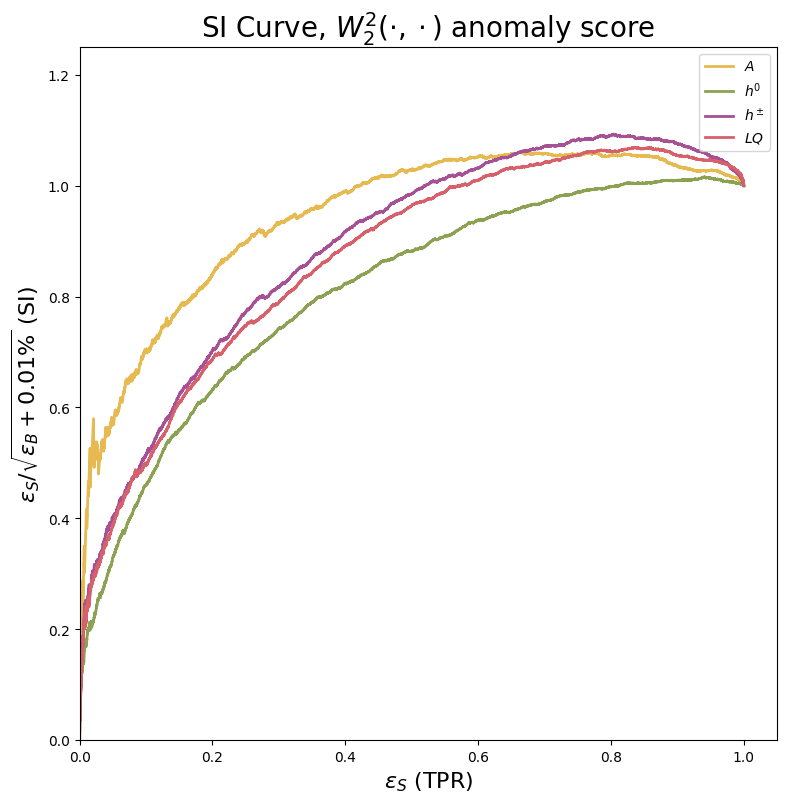

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.25)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.0001 0.0008 0.0008 0.001 ]
[0.         0.01       0.08       0.05656854 0.07071068]


### Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.6863426399999999
     $h^0$: 0.62898771
   $h^\pm$: 0.6839684399999999
      $LQ$: 0.6714957500000001


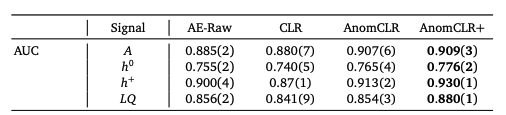

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[1474, 2072, 1744, 1858]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 9.652509652509652 (TPR=0.3)
     $h^0$: 6.134969325153374 (TPR=0.2998)
   $h^\pm$: 7.434944237918216 (TPR=0.3)
      $LQ$: 6.93000693000693 (TPR=0.3)


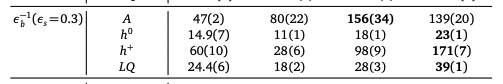

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.9316051410668053 (TPR=0.3)
     $h^0$: 0.7423430518444317 (TPR=0.2998)
   $h^\pm$: 0.8177089002010761 (TPR=0.3)
      $LQ$: 0.7894736842105263 (TPR=0.3)


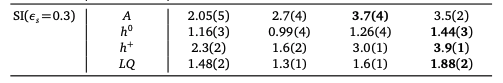